# **Chest X-ray Image Classification: Deep Learning Analysis (Multi-label Classification)**
**`Domain: Medical Imaging`**

I selected **Advanced – 1 Chest X-Ray Images for Classification** from the **Suggested Datasets** document as my **AML-AD project**.  
The dataset was released by **University of California San Diego (UCSD)** and is hosted on the **Mendeley Data platform**.

This project aims to build a deep learning model for large-scale medical images to perform binary classification of chest X-rays: **PNEUMONIA vs NORMAL**.

`Technical highlights include:`  
- Following a complete machine-learning workflow and implementing it with **PyTorch**.
- Preprocessing for **complex images**.  
- Multiple **performance optimizations** to address storage and computation for large-scale imaging data.
- Handling **severe class imbalance** while balancing model effectiveness and training efficiency.

# **1. Basic Environment Setup**

In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random, numpy as np, torch
import math
from torch.utils.data import DataLoader 
from torchvision import datasets, models, transforms
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from PIL import Image


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU configured and enabled!")
    print("Using device:", torch.cuda.get_device_name(0))
else:
    print("Warning: No GPU found. Training will run on CPU and be slower.")
    print("Using device: CPU")

# Create folder to save figures
FIGS_DIR = 'figs'
if not os.path.exists(FIGS_DIR):
    os.makedirs(FIGS_DIR)

# Set global random seed
SEED = 20240924

# Python builtin random
random.seed(SEED)
# Numpy
np.random.seed(SEED)
# PyTorch CPU
torch.manual_seed(SEED)
# PyTorch GPU
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # for multi-GPU

# cuDNN 
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.set_float32_matmul_precision('high')   # TF32

GPU configured and enabled!
Using device: NVIDIA GeForce RTX 3070 Laptop GPU


**Explanation:**  
Improve experiment reproducibility by setting a **global random seed**.

**Performance optimizations:**：  
- Enable **cuDNN benchmark** to let cuDNN automatically choose the fastest convolution kernels.
- Enable **TensorFloat-32 (TF32)** to accelerate matrix multiplications.
- Disable **cuDNN deterministic** to allow non-deterministic algorithms for higher performance.

# **2. Exploratory Data Analysis (EDA)**

class_to_idx: {'NORMAL': 0, 'PNEUMONIA': 1}
--- Class Distribution ---
pos_weight for BCE (weakened, sqrt) = 0.589
Train: NORMAL 1349 imgs, PNEUMONIA 3883 imgs
Test : NORMAL 234 imgs, PNEUMONIA 390 imgs


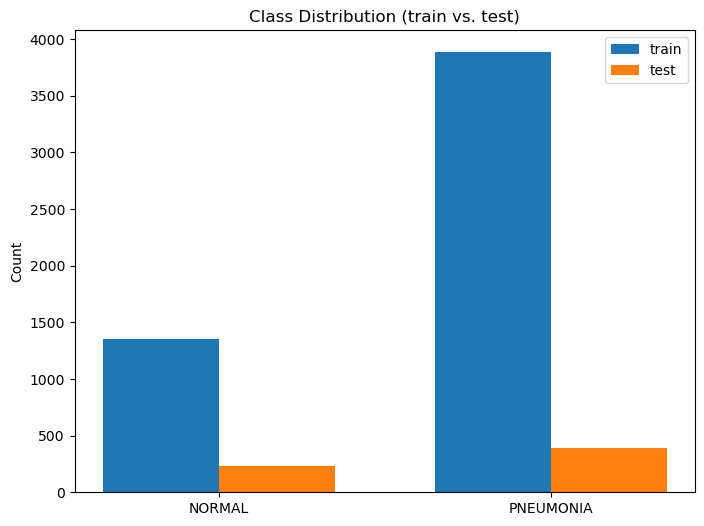

In [2]:
# Define dataset paths
BASE_PATH = r"C:\Users\b1795\Desktop\AML_AD_v1\chest_xray"
TRAIN_DIR = os.path.join(BASE_PATH, "train")
TEST_DIR = os.path.join(BASE_PATH, "test")

# Temporarily load datasets for quick EDA
temp_full_train_dataset = datasets.ImageFolder(root=TRAIN_DIR)
temp_test_dataset = datasets.ImageFolder(root=TEST_DIR)
print("class_to_idx:", temp_full_train_dataset.class_to_idx) 

# Verify class imbalance
print("--- Class Distribution ---")
train_counts = [0, 0]
for _, index in temp_full_train_dataset:
    train_counts[index] += 1

# === Prepare pos_weight (for BCEWithLogitsLoss) to mitigate imbalance ===
# Convention: 0 = NORMAL (negative), 1 = PNEUMONIA (positive)
NEG_TRAIN, POS_TRAIN = train_counts[0], train_counts[1]

# Raw ratio
ratio = NEG_TRAIN / max(POS_TRAIN, 1)

# Weaken with sqrt
pos_weight_value = np.sqrt(ratio)
print(f"pos_weight for BCE (weakened, sqrt) = {pos_weight_value:.3f}")

# Tensor for criterion
pos_weight = torch.tensor([pos_weight_value], device=device, dtype=torch.float32)


test_counts = [0, 0]
for _, index in temp_test_dataset:
    test_counts[index] += 1

print(f"Train: NORMAL {train_counts[0]} imgs, PNEUMONIA {train_counts[1]} imgs")
print(f"Test : NORMAL {test_counts[0]} imgs, PNEUMONIA {test_counts[1]} imgs")

# Plot bars to visualize class imbalance
train_labels = ['NORMAL', 'PNEUMONIA']
test_labels = ['NORMAL', 'PNEUMONIA']
train_counts_array = np.array(train_counts)
test_counts_array = np.array(test_counts)

x = np.arange(len(train_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, train_counts_array, width, label='train')
rects2 = ax.bar(x + width/2, test_counts_array, width, label='test')

ax.set_ylabel('Count')
ax.set_title('Class Distribution (train vs. test)')
ax.set_xticks(x)
ax.set_xticklabels(train_labels)
ax.legend()
plt.savefig(os.path.join(FIGS_DIR, "class_distribution.png"), bbox_inches='tight', pad_inches=0.02, dpi=200)
plt.show()

**Explanation:**  
This dataset shows a significant **class imbalance—there** are far more **PNEUMONIA** images than **NORMAL** images.  
To mitigate this, we define a **pos_weight** (used by **BCEWithLogitsLoss**) and apply a **square-root weakening strategy** to avoid overly penalizing the minority class.  
In subsequent training, we will further address imbalance using **data augmentation** and **threshold tuning** to reduce its negative impact on model performance.

# **3. Data Processing and Loading**

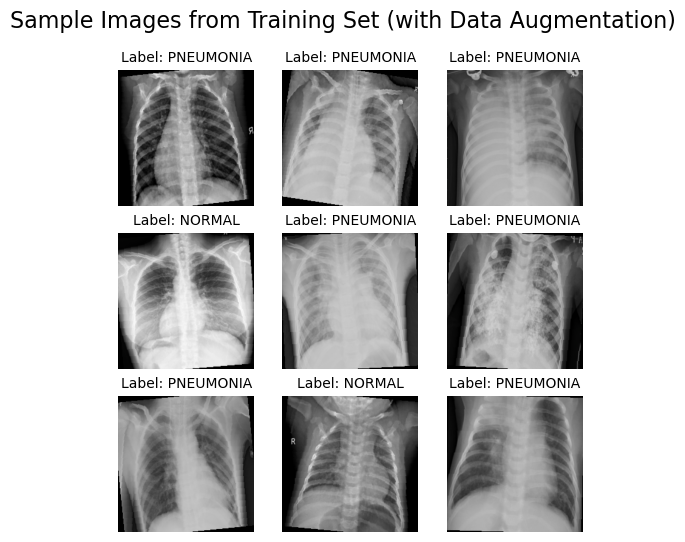

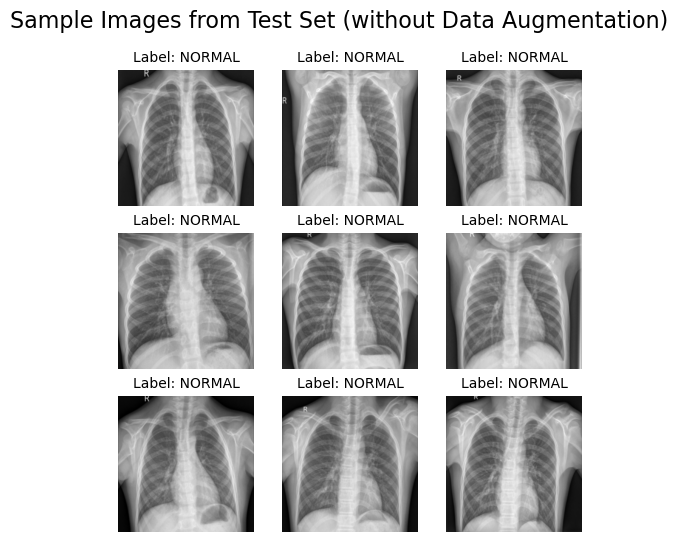

In [3]:
# Define image transforms and data augmentation
IMG_SIZE = (224, 224)

train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Build a plain (no transform) dataset to get indices
full_plain = datasets.ImageFolder(root=TRAIN_DIR)
n = len(full_plain)
train_size = int(0.8 * n); val_size = n - train_size
train_idx, val_idx = torch.utils.data.random_split(range(n), [train_size, val_size])

# Bind different transforms for train/val
train_base = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)
val_base   = datasets.ImageFolder(root=TRAIN_DIR, transform=test_transforms)

# Subset by indices
train_dataset = torch.utils.data.Subset(train_base, train_idx.indices if hasattr(train_idx,'indices') else train_idx)
val_dataset   = torch.utils.data.Subset(val_base,   val_idx.indices   if hasattr(val_idx,'indices')   else val_idx)

# Test set as usual
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=test_transforms)

# Create dataloaders
from torch.utils.data import WeightedRandomSampler

BATCH_SIZE = 32


# === Compute sampling weights for train_dataset (Subset) ===
if isinstance(train_dataset, torch.utils.data.Subset):
    indices = train_dataset.indices
    base_ds = train_dataset.dataset   # equals the underlying ImageFolder
else:
    indices = list(range(len(train_dataset)))
    base_ds = train_dataset

# Get labels for each sample in the Subset (0:NORMAL, 1:PNEUMONIA)
labels_in_subset = [base_ds.samples[i][1] for i in indices]

# Count per-class samples and build inverse-frequency weights
class_counts = np.bincount(labels_in_subset, minlength=2)      # [#normal, #pneu]
class_weights = 1.0 / np.clip(class_counts, 1, None)           # avoid zeros

sample_weights = torch.as_tensor([class_weights[y] for y in labels_in_subset], dtype=torch.double)

gen = torch.Generator()  # keep handle; change seed each epoch if needed
gen.manual_seed(SEED)
sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),    # draw this many per epoch
    replacement=True,
    generator=gen
)


train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,sampler=sampler,num_workers=4, prefetch_factor=4, pin_memory=torch.cuda.is_available(), drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, prefetch_factor=4, pin_memory=torch.cuda.is_available(), drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4,  prefetch_factor=4, pin_memory=torch.cuda.is_available(), drop_last=False)



# Visualize a few samples
labels = {0: "NORMAL", 1: "PNEUMONIA"}

def plot_images(loader, title, filename=None):
    images, labels_ = next(iter(loader))
    plt.figure(figsize=(6, 6))
    plt.suptitle(title, fontsize=16)
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        # PyTorch tensors need transpose and de-normalization for correct display
        img = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"Label: {labels[int(labels_[i])]}", fontsize=10)
        plt.axis("off")
    if filename:
        plt.savefig(os.path.join(FIGS_DIR, filename))
    plt.show()

plot_train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
plot_test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
plot_images(plot_train_loader, "Sample Images from Training Set (with Data Augmentation)", "train_samples.png")
plot_images(plot_test_loader, "Sample Images from Test Set (without Data Augmentation) ", "test_samples.png")

**Explanation:**
**Image Processing:**
- *Resize & Normalize*

**Class Imbalance Optimization Strategies:**
- Allocate an additional *20%* **validation set**, used to detect underfitting/overfitting, and to support early stopping and hyperparameter tuning.
- Use **WeightedRandomSampler** to increase the probability of sampling minority classes (complementary to **pos_weight**).
- Perform **data augmentation** on the training dataset to improve model generalization ability.  
Pipeline: *Resize → RandomHorizontalFlip → RandomRotation → ToTensor → Normalize.*

**Performance Optimization:**
- **Data loading acceleration**: *(num_workers=4, prefetch_factor=4, pin_memory=True)* to improve throughput and GPU memory utilization.
- Appropriate **batch size**: **BATCH_SIZE = 32**, balancing speed and stability.

# **4. Core Training and Evaluation Functions**

In [4]:
def sigmoid_numpy(x):
    return 1 / (1 + np.exp(-x))

@torch.no_grad()
def evaluate_model(model, loader, thr: float = 0.5):
    model.eval()
    all_logits, all_labels = [], []
    for imgs, labels_tensor in loader:
        imgs = imgs.to(device, non_blocking=True).to(memory_format=torch.channels_last)
        labels_tensor = labels_tensor.float().to(device, non_blocking=True)


        with torch.amp.autocast("cuda", dtype=torch.float16):
            logits = model(imgs).squeeze(-1)
        all_logits.append(logits.detach().cpu().numpy())
        all_labels.append(labels_tensor.detach().cpu().numpy())

    logits = np.concatenate(all_logits).astype(np.float32)
    labels = np.concatenate(all_labels)
    probs = sigmoid_numpy(logits)
    preds = (probs >= thr).astype(int)

    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    # Macro-averaged metrics (balances the two classes)
    prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
        labels, preds, average='macro', zero_division=0
    )
    try:
        auc_val = roc_auc_score(labels, probs)
    except ValueError:
        auc_val = float('nan')

    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc_val, "f1_macro": f1_m, "probs": probs, "labels": labels}


def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, model_name, num_epochs=15, patience=3, min_delta = 1e-4):
    best_metric = float('-inf')  # Monitor AUC
    wait = 0
    history = []
    
    print(f"--- Start training {model_name} ---")

    scaler = torch.amp.GradScaler("cuda")

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        start_time = time.time()
    
        
        for i, (inputs, labels) in enumerate(train_loader):
            # Move data to GPU, set channels_last memory layout
            inputs = inputs.to(device, non_blocking=True).to(memory_format=torch.channels_last)
           # Labels need only float + GPU; channels_last is not needed
            labels = labels.float().to(device, non_blocking=True).unsqueeze(1)
            optimizer.zero_grad(set_to_none=True)
            # AMP forward (float16 on Tensor Cores)
            with torch.amp.autocast("cuda", dtype=torch.float16):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # AMP backward/update
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
        
        # On-the-fly evaluation
        val_metrics = evaluate_model(model, val_loader)
        history.append((running_loss/len(train_loader), val_metrics))
        
        # Prefer macro F1 for display
        val_f1_to_show   = val_metrics.get('f1_macro',   val_metrics['f1'])

        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"Train Loss: {running_loss/len(train_loader):.4f} | "
            f"Val F1: {val_f1_to_show:.4f} | "
            f"Val AUC: {val_metrics['auc']:.4f} | "
            f"Time: {time.time() - start_time:.1f}s")
        
        # Early stopping: monitor validation AUC
        metric = val_metrics['auc']
        
        if math.isnan(metric):  # If AUC is NaN (e.g., val set has a single class), treat as very poor
            metric = float('-inf')

        if best_metric == float('-inf'):
            print(f"[ES] AUC={metric:.6f} best=None Δ=-- wait={wait}")
        else:
            print(f"[ES] AUC={metric:.6f} best={best_metric:.6f} Δ={metric - best_metric:.6f} wait={wait}")

        if metric > best_metric + min_delta:
            best_metric = metric
            wait = 0
            torch.save(model.state_dict(), f"{model_name}_best_model.pth")
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at Epoch {epoch} (best AUC: {best_metric:.4f})")
                break
    
    print("-" * 20)
    return history

**Explanation:**
**Evaluation & Metrics:**
- Unified evaluation function: **evaluate_model**
- Probability & threshold: *thr=0.5*, with further threshold tuning in later steps.
- Training loop supports logging and visualization.

**Support for Early Stopping:**
- Monitor metric: validation **AUC** as the main criterion, with *patience=3, min_delta=1e-4*.

**Performance Optimization:**
- Automatic Mixed Precision (**AMP**):  *Autocast(fp16) + GradScaler*, significantly improving speed and reducing memory usage.
- Memory layout: **channels_last** for faster convolution.
- Data transfer: **non_blocking=True** to reduce waiting time during data copy.

# **5. Baseline Model (Simple CNN)**
**Build a simple Convolutional Neural Network (CNN) as the baseline model, which is more complex than the DummyClassifier and can learn image features.**  
**Note:** *DummyClassifier* only makes predictions randomly or based on class distribution, without learning from data. In contrast, a *CNN* can extract spatial patterns and meaningful features from images.

In [5]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(32 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

baseline_model = SimpleCNN().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer_cnn = optim.AdamW(baseline_model.parameters(), lr=1e-3, weight_decay=1e-4)

# Train the baseline model
train_and_evaluate(baseline_model, train_loader, val_loader, optimizer_cnn, criterion, "baseline_cnn")

--- Start training baseline_cnn ---
Epoch 1/15 | Train Loss: 0.2085 | Val F1: 0.9268 | Val AUC: 0.9881 | Time: 60.6s
[ES] AUC=0.988086 best=None Δ=-- wait=0
Epoch 2/15 | Train Loss: 0.1314 | Val F1: 0.9456 | Val AUC: 0.9896 | Time: 58.6s
[ES] AUC=0.989588 best=0.988086 Δ=0.001503 wait=0
Epoch 3/15 | Train Loss: 0.1233 | Val F1: 0.9331 | Val AUC: 0.9907 | Time: 59.4s
[ES] AUC=0.990685 best=0.989588 Δ=0.001096 wait=0
Epoch 4/15 | Train Loss: 0.0976 | Val F1: 0.9309 | Val AUC: 0.9857 | Time: 59.3s
[ES] AUC=0.985687 best=0.990685 Δ=-0.004998 wait=0
Epoch 5/15 | Train Loss: 0.1100 | Val F1: 0.9460 | Val AUC: 0.9918 | Time: 58.6s
[ES] AUC=0.991783 best=0.990685 Δ=0.001098 wait=1
Epoch 6/15 | Train Loss: 0.1059 | Val F1: 0.9220 | Val AUC: 0.9885 | Time: 59.0s
[ES] AUC=0.988483 best=0.991783 Δ=-0.003300 wait=0
Epoch 7/15 | Train Loss: 0.0929 | Val F1: 0.9066 | Val AUC: 0.9932 | Time: 59.3s
[ES] AUC=0.993172 best=0.991783 Δ=0.001389 wait=1
Epoch 8/15 | Train Loss: 0.0956 | Val F1: 0.8820 | Val 

[(0.20850708900162807,
  {'acc': 0.9455587392550143,
   'prec': 0.9488139825218477,
   'rec': 0.979381443298969,
   'f1': 0.963855421686747,
   'auc': 0.9880858409099554,
   'f1_macro': 0.9268019855048821,
   'probs': array([0.9982039 , 0.99268264, 0.9838472 , ..., 0.00841298, 0.56166565,
          0.99457306], shape=(1047,), dtype=float32),
   'labels': array([1., 1., 1., ..., 0., 0., 1.], shape=(1047,), dtype=float32)}),
 (0.13140989938894143,
  {'acc': 0.9579751671442216,
   'prec': 0.9753246753246754,
   'rec': 0.9677835051546392,
   'f1': 0.9715394566623544,
   'auc': 0.9895884848023737,
   'f1_macro': 0.9456237429297174,
   'probs': array([0.99861693, 0.9859904 , 0.99621993, ..., 0.00141587, 0.2013417 ,
          0.9931496 ], shape=(1047,), dtype=float32),
   'labels': array([1., 1., 1., ..., 0., 0., 1.], shape=(1047,), dtype=float32)}),
 (0.12328660579828116,
  {'acc': 0.9465138490926457,
   'prec': 0.9864864864864865,
   'rec': 0.9407216494845361,
   'f1': 0.9630606860158312,
 

# **6. Advanced Model: Transfer Learning with ResNet50**

**Use ResNet50 as the advanced model. Transfer learning leverages strong feature representations learned from large-scale datasets, which accelerates training and improves performance.**  
**Note:** Compared to the simple *CNN baseline*, *ResNet50* provides deeper architecture and pre-trained knowledge, making it more effective for complex image classification tasks.

In [6]:
advanced_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = advanced_model.fc.in_features
advanced_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 1)
)
advanced_model = advanced_model.to(device, memory_format=torch.channels_last)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# Hyperparameters: LR is a key knob—feel free to tune it
optimizer_resnet = optim.AdamW(advanced_model.parameters(), lr=1e-4, weight_decay=1e-4)

# Train the advanced model
train_and_evaluate(advanced_model, train_loader, val_loader, optimizer_resnet, criterion, "advanced_resnet")

--- Start training advanced_resnet ---
Epoch 1/15 | Train Loss: 0.1782 | Val F1: 0.9509 | Val AUC: 0.9973 | Time: 114.7s
[ES] AUC=0.997318 best=None Δ=-- wait=0
Epoch 2/15 | Train Loss: 0.0509 | Val F1: 0.9601 | Val AUC: 0.9981 | Time: 114.1s
[ES] AUC=0.998088 best=0.997318 Δ=0.000770 wait=0
Epoch 3/15 | Train Loss: 0.0375 | Val F1: 0.9913 | Val AUC: 0.9984 | Time: 118.5s
[ES] AUC=0.998440 best=0.998088 Δ=0.000352 wait=0
Epoch 4/15 | Train Loss: 0.0365 | Val F1: 0.9812 | Val AUC: 0.9990 | Time: 114.7s
[ES] AUC=0.998954 best=0.998440 Δ=0.000514 wait=0
Epoch 5/15 | Train Loss: 0.0212 | Val F1: 0.9852 | Val AUC: 0.9992 | Time: 113.7s
[ES] AUC=0.999225 best=0.998954 Δ=0.000271 wait=0
Epoch 6/15 | Train Loss: 0.0224 | Val F1: 0.9901 | Val AUC: 0.9992 | Time: 114.4s
[ES] AUC=0.999158 best=0.999225 Δ=-0.000067 wait=0
Epoch 7/15 | Train Loss: 0.0153 | Val F1: 0.9900 | Val AUC: 0.9995 | Time: 113.9s
[ES] AUC=0.999486 best=0.999225 Δ=0.000262 wait=1
Epoch 8/15 | Train Loss: 0.0185 | Val F1: 0.99

[(0.1782041231313577,
  {'acc': 0.9608404966571156,
   'prec': 0.9946164199192463,
   'rec': 0.9523195876288659,
   'f1': 0.9730085582620145,
   'auc': 0.9973180659641647,
   'f1_macro': 0.9508521052179637,
   'probs': array([9.9928480e-01, 9.8636311e-01, 9.9190676e-01, ..., 3.5006861e-04,
          7.5581729e-01, 7.6734138e-01], shape=(1047,), dtype=float32),
   'labels': array([1., 1., 1., ..., 0., 0., 1.], shape=(1047,), dtype=float32)}),
 (0.050941325423236074,
  {'acc': 0.9684813753581661,
   'prec': 0.9946737683089214,
   'rec': 0.9626288659793815,
   'f1': 0.9783889980353635,
   'auc': 0.9980884087191387,
   'f1_macro': 0.9600939699171527,
   'probs': array([9.9999905e-01, 9.9995565e-01, 9.9624926e-01, ..., 9.7615659e-05,
          6.5412188e-01, 9.6703881e-01], shape=(1047,), dtype=float32),
   'labels': array([1., 1., 1., ..., 0., 0., 1.], shape=(1047,), dtype=float32)}),
 (0.03748287505720957,
  {'acc': 0.9933142311365807,
   'prec': 0.9961290322580645,
   'rec': 0.9948453608

# **7. Final Evaluation**  
- Threshold search objective function is **Balanced Accuracy**, which balances **“detecting pneumonia” (TPR)** and **“not misclassifying normal cases” (TNR)**.  
- Includes a **safety constraint**:  *(TNR ≥ 0.5 & threshold ≥ 0.5)*  
- **Evaluate_model** provides a unified evaluation pipeline, supporting printing and saving of the **confusion matrix**.

The best threshold found on the validation set: 0.9490 (Balanced Acc: 0.9332, TPR=0.874, TNR=0.993)
Safeguard: TNR ≥ 0.93, Threshold lower bound = 0.9
Final threshold (with lower bound applied): 0.9490
baseline best thr = 0.9490
The best threshold found on the validation set: 0.9600 (Balanced Acc: 0.9853, TPR=0.974, TNR=0.996)
Safeguard: TNR ≥ 0.93, Threshold lower bound = 0.9
Final threshold (with lower bound applied): 0.9600
advanced best  thr = 0.9600

--- Baseline CNN Performance Report ---
              precision    recall  f1-score   support

      NORMAL      0.852     0.786     0.818       234
   PNEUMONIA      0.877     0.918     0.897       390

    accuracy                          0.869       624
   macro avg      0.865     0.852     0.858       624
weighted avg      0.868     0.869     0.867       624

ROC-AUC: 0.922
Balanced Acc: 0.852

--- Advanced ResNet50 Performance Report ---
              precision    recall  f1-score   support

      NORMAL      0.969     0.808    

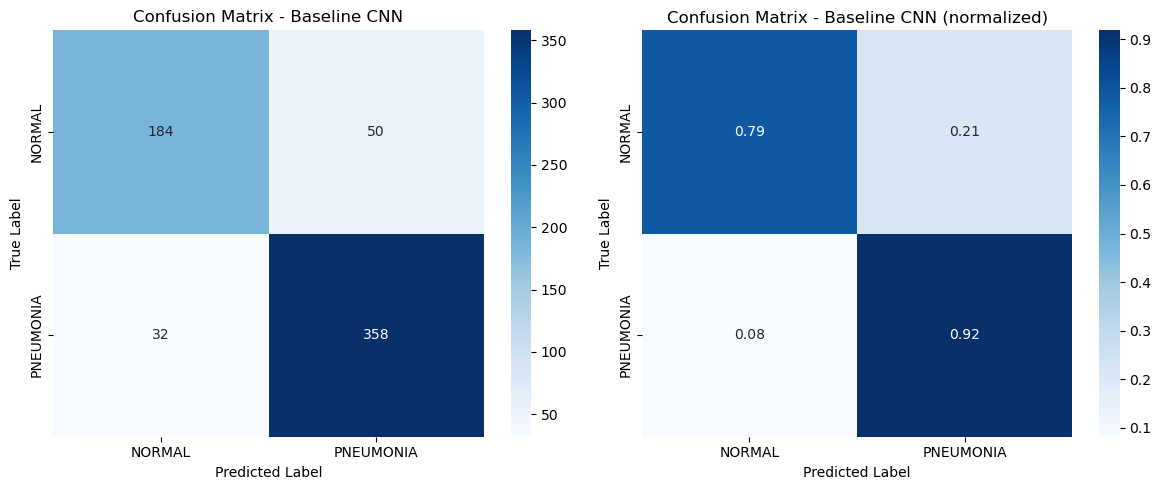

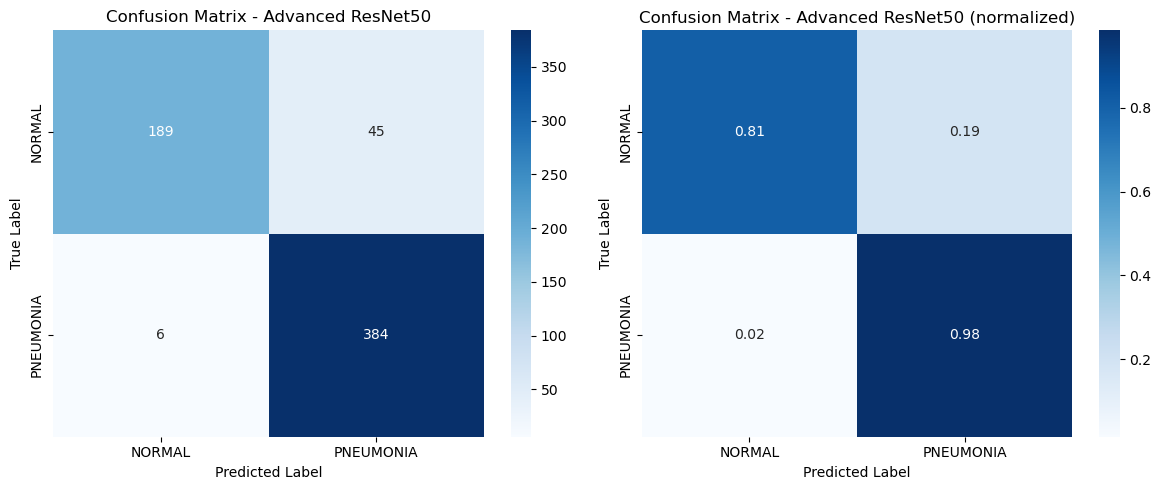

In [ ]:
@torch.no_grad()
def find_best_threshold(model, val_loader, tnr_target: float = 0.93, min_thr: float = 0.90):
    model.eval()
    results = evaluate_model(model, val_loader)
    probs = results['probs']
    labels = results['labels']

    thresholds = np.linspace(0.0, 1.0, 1001)

    # —— Select threshold by Balanced Accuracy = (TPR + TNR)/2 ——
    from sklearn.metrics import recall_score
    stats = []
    for thr in thresholds:
        preds = (probs >= thr).astype(int)
        tpr = recall_score(labels, preds, pos_label=1, zero_division=0)            # recall for PNEUMONIA
        tnr = recall_score(1 - labels, 1 - preds, pos_label=1, zero_division=0)    # recall for NORMAL
        ba  = 0.5 * (tpr + tnr)

        # soft score: bias towards TNR + higher threshold
        score = 0.7 * tnr + 0.3 * tpr + 0.05 * thr


        stats.append(dict(thr=thr, tpr=tpr, tnr=tnr, ba=ba, score=score))


    # Select best threshold by soft score
    best = max(stats, key=lambda s: s["score"])

    # If the soft-selected threshold does not satisfy the hard constraints → fallback
    if best["tnr"] < tnr_target or best["thr"] < min_thr:
        candidates = [s for s in stats if s["tnr"] >= tnr_target and s["thr"] >= min_thr]
        if len(candidates) > 0:
            best = max(candidates, key=lambda s: s["score"])

    print(f"The best threshold found on the validation set: {best['thr']:.4f} "
        f"(Balanced Acc: {best['ba']:.4f}, "
        f"TPR={best['tpr']:.3f}, TNR={best['tnr']:.3f})")
    
    print(f"Safeguard: TNR ≥ {tnr_target}, Threshold lower bound = {min_thr}")

    # --- Final safeguard: do not go below min_thr ---
    best_thr = max(best['thr'], min_thr)
    print(f"Final threshold (with lower bound applied): {best_thr:.4f}")

    return best_thr


# Evaluate baseline model
baseline_model.load_state_dict(torch.load('baseline_cnn_best_model.pth', map_location=device, weights_only=True))
baseline_model.eval()
best_thr_baseline = find_best_threshold(baseline_model, val_loader)
print(f"baseline best thr = {best_thr_baseline:.4f}")
b_test = evaluate_model(baseline_model, test_loader)
baseline_probs  = b_test['probs']
baseline_labels = b_test['labels']
baseline_preds  = (baseline_probs >= best_thr_baseline).astype(int)

# Evaluate advanced model
advanced_model.load_state_dict(torch.load('advanced_resnet_best_model.pth', map_location=device, weights_only=True))
advanced_model.eval()
best_thr_advanced = find_best_threshold(advanced_model, val_loader)
print(f"advanced best  thr = {best_thr_advanced:.4f}")
a_test = evaluate_model(advanced_model, test_loader)
advanced_probs  = a_test['probs']
advanced_labels = a_test['labels']
advanced_preds  = (advanced_probs >= best_thr_advanced).astype(int)

from sklearn.metrics import balanced_accuracy_score, roc_auc_score

def summarize(labels, preds, probs, name):
    print(f"\n--- {name} ---")
    print(classification_report(labels, preds, target_names=['NORMAL', 'PNEUMONIA'], digits=3))
    try:
        auc = roc_auc_score(labels, probs)
        print(f"ROC-AUC: {auc:.3f}")
    except ValueError:
        print("ROC-AUC: n/a")
    ba = balanced_accuracy_score(labels, preds)
    print(f"Balanced Acc: {ba:.3f}")

# Baseline
summarize(baseline_labels, baseline_preds, baseline_probs, "Baseline CNN Performance Report")
# Advanced
summarize(advanced_labels, advanced_preds, advanced_probs, "Advanced ResNet50 Performance Report")


# Plot raw & normalized confusion matrices side-by-side
def plot_confmat_pair(y_true, y_pred, model_name: str):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, normalize, title_suffix in [
        (axes[0], None, ''),          # Raw counts
        (axes[1], 'true', ' (normalized)')  # Row-normalized
    ]:
        cm = confusion_matrix(y_true, y_pred, normalize=normalize)
        sns.heatmap(cm, annot=True,
                    fmt='.2f' if normalize else 'd',
                    cmap='Blues',
                    xticklabels=['NORMAL','PNEUMONIA'],
                    yticklabels=['NORMAL','PNEUMONIA'],
                    ax=ax)
        ax.set_title(f'Confusion Matrix - {model_name}{title_suffix}')
        ax.set_xlabel('Predicted Label'); ax.set_ylabel('True Label')

    plt.tight_layout()
    fn = f"{model_name.replace(' ', '_')}_confusion_matrix_pair.png"
    plt.savefig(os.path.join(FIGS_DIR, fn), bbox_inches='tight', dpi=200)
    plt.show()

# Call once per model
plot_confmat_pair(baseline_labels, baseline_preds, "Baseline CNN")
plot_confmat_pair(advanced_labels, advanced_preds, "Advanced ResNet50")

**Thresholding strategy:**  
To reduce false decisions in clinical usage, we combined a *soft* cost-sensitive scoring objective with a *hard* safety constraint during threshold selection. The soft term encourages conservative thresholds that favor a higher TNR, while the hard constraint enforces **TNR ≥ 0.93** with a **minimum threshold ≥ 0.90**. This two-level design slightly trades TPR for markedly more reliable behavior.

**Why it matters for this dataset:**  
Given the strong class imbalance in *ChestXRay2017*, such combined constraints are necessary to **mitigate bias and stabilize performance**.

**Key findings (this run):**

*Baseline CNN* tends to over-predict Pneumonia, misclassifying many normal cases  
**→ Balanced Acc = 0.852, AUC = 0.922; TNR ≈ 0.786, TPR ≈ 0.918**.

*Transfer learning with ResNet50* is **more robust**. While maintaining a **very high pneumonia recall (TPR ≈ 0.985)**, it also improves the correct recognition of normal cases **(TNR ≈ 0.808)**.  
**→ Balanced Acc increases to 0.896, AUC reaches 0.980**.  
→ At the tuned thresholds, **FN drops from 32 to 6 and FP decreases from 50 to 45**.  

With *multiple imbalance-aware techniques* (WeightedRandomSampler + pos_weight) and GPU optimizations (AMP), **training was efficient** and **generalization improved** over the baseline.  

**Next steps:**  
We will validate on **external datasets** and refine threshold calibration to further enhance stability and clinical applicability.

# **8. Explainability Analysis (Grad-CAM)**

- Attach a hook to *layer4 of ResNet50* to capture forward **feature maps** and backward **gradients**.  
- Compute **channel weights = spatial average of gradients**, apply weighted sum on the feature maps to obtain the **heatmap**.  
- Overlay the **heatmap onto the original image**   *(JET colormap + α blending)*.

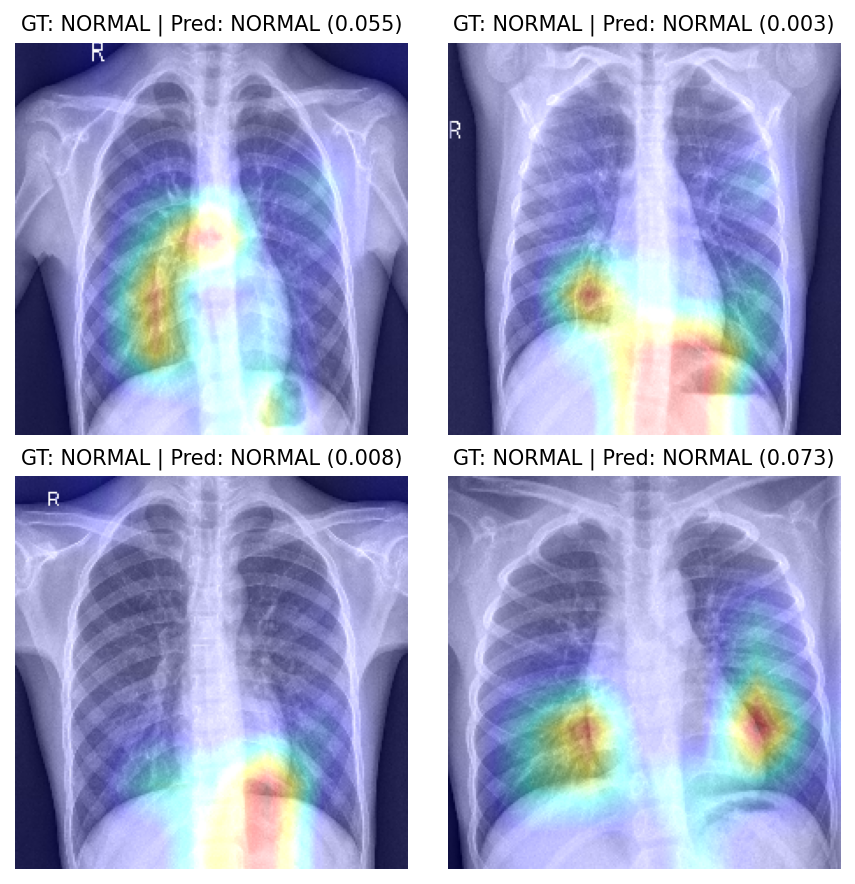

In [8]:
class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer = None
        self.gradients = None
        self.activations = None
        
        def save_activation(module, input, output):
            self.activations = output
        
        def save_gradient(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        for name, module in self.model.named_modules():
            if name == target_layer_name:
                module.register_forward_hook(save_activation)
                module.register_full_backward_hook(save_gradient)
                break
        else:
            raise ValueError(f"Target layer '{target_layer_name}' not found in model.")
        
    def __call__(self, x, class_idx=None):
        self.model.eval()
        output = self.model(x)
        
        # 统一成 [1, C]
        if output.ndim == 1:
            output = output.view(1, -1)

        # 若未指定 class_idx，自动选择
        if class_idx is None:
            if output.shape[1] == 1:
                # 二分类单logit：用概率判断当前样本更像正类还是负类
                class_idx = 1 if torch.sigmoid(output)[0, 0] >= 0.5 else 0
            else:
                class_idx = torch.argmax(output, dim=1).item()
            
        self.model.zero_grad(set_to_none=True)



        if output.shape[1] == 1:
            # 二分类单logit的正确反传方式：
            # 解释“正类”→ 对 +logit 反传；解释“负类”→ 对 -logit 反传
            score = output[0, 0] if int(class_idx) == 1 else -output[0, 0]
            score.backward()
        else:
            # 多分类保持原来的 one-hot 反传
            one_hot = torch.zeros_like(output)
            one_hot[0, int(class_idx)] = 1
            output.backward(gradient=one_hot)


        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations
        
        for i in range(pooled_gradients.shape[0]):
            activations[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activations, dim=1).squeeze().cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap = heatmap / (np.max(heatmap) + 1e-8)
        return heatmap

# Visualization helper
def save_and_display_gradcam(img_path, heatmap, alpha=0.4, filename=None):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    if filename:
        plt.savefig(os.path.join(FIGS_DIR, filename))
    plt.show()

# Pick images to explain
test_images_paths = [test_dataset.imgs[i][0] for i in range(5)]
test_images_labels = [labels[test_dataset.imgs[i][1]] for i in range(5)]

# Load model
advanced_model.load_state_dict(torch.load('advanced_resnet_best_model.pth', map_location='cpu', weights_only=True))
advanced_model.eval()

# Create Grad-CAM instance
target_layer_name = 'layer4'
grad_cam = GradCAM(advanced_model, target_layer_name)

# Build subplots
# Select 4 test images
N_SHOW = 4
idxs = list(range(N_SHOW))
test_images_paths  = [test_dataset.imgs[i][0] for i in idxs]
test_images_labels = [labels[test_dataset.imgs[i][1]] for i in idxs]

# Ensure model and inputs are on the same device
advanced_model.load_state_dict(torch.load('advanced_resnet_best_model.pth', map_location=device, weights_only=True))
advanced_model = advanced_model.to(device)
advanced_model.eval()

# Grad-CAM
target_layer_name = 'layer4'
grad_cam = GradCAM(advanced_model, target_layer_name)

# 2x2 grid; smaller images(6,6);
fig, axes = plt.subplots(2, 2, figsize=(6, 6), dpi=150)
axes = axes.flatten()

for i in range(N_SHOW):
    img_path = test_images_paths[i]
    gt_label = test_images_labels[i]

    # Read image + preprocessing
    img_PIL = Image.open(img_path).convert('RGB')
    input_tensor = test_transforms(img_PIL).unsqueeze(0).to(device)

    # Prediction (probability)
    with torch.no_grad():
        logits = advanced_model(input_tensor)
        prob = torch.sigmoid(logits).item()
    pred_idx = 1 if prob > 0.5 else 0
    pred_label = labels[pred_idx]

    # Grad-CAM heatmap
    heatmap = grad_cam(input_tensor, class_idx=pred_idx)
    img_cv2 = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_cv2 = cv2.resize(img_cv2, (IMG_SIZE[1], IMG_SIZE[0]))
    heatmap = cv2.resize(heatmap, (img_cv2.shape[1], img_cv2.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = np.clip(0.35 * heatmap + img_cv2, 0, 255).astype(np.uint8)

    # Show
    ax = axes[i]
    ax.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    ax.set_title(f"GT: {gt_label} | Pred: {pred_label} ({prob:.3f})", fontsize=10)
    ax.axis("off")

plt.tight_layout(w_pad=0.6, h_pad=0.6)
plt.savefig(os.path.join(FIGS_DIR, "grad_cam_2x2.png"), bbox_inches='tight', dpi=200)
plt.show()

1) *Primary Focus Is Reasonable*:  
High activations (red/yellow) concentrate in the **bilateral lung fields** and along the **cardiac silhouette**; low activations (blue/green) appear on clavicles/soft tissue—consistent with expected CXR focus.
2) *Confidence Aligns with Visualization*:  
The value in parentheses is the **probability of NORMAL**; low values (e.g., 0.003–0.073) mean **higher confidence for NORMAL**. Maps focus on **clear lung parenchyma** with no spurious peaks.
3) *Minor Non-Pulmonary Activations Are Typical Artifacts*:  
Mild activations near **diaphragmatic domes** or **cardiophrenic angles** are common weakly-supervised artifacts (edge/contrast effects) and do not affect conclusions.
4) *Conclusion*:  
The model bases its **NORMAL** decision on **intra-pulmonary cues, without relying on irrelevant regions**—consistent with the strong TNR and AUC in this run.

**Limitations & Future Work**:  
Grad-CAM is low-resolution; future work may use **higher-resolution attention maps** or **box/segmentation supervision** to improve localization and interpretability.